# **8장 성능 최적화**

## **8.3 하이퍼파라미터를 이용한 성능 최적화**

### **8.3.2 드롭아웃을 이용한 성능 최적화**

#### **파이토치 예제**

##### **1. 라이브러리 호출**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

##### **2. 데이터셋 내려받기**

In [4]:
trainset=torchvision.datasets.FashionMNIST(
    root='/content/drive/MyDrive/24-2/EURON/과제', train=True,
    download=True,
    transform=transforms.ToTensor()
)

##### **3. 데이터셋을 메모리로 가져오기**

In [5]:
batch_size=4
trainloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

`batch_size=4`: 데이터를 메모리로 가져올 때 한 번에 4개씩 쪼개서 가져온다.

##### **4. 데이터셋 분리**

In [6]:
dataiter=iter(trainloader)
images, labels=next(dataiter)

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
0


##### **5. 이미지 데이터를 출력하기 위한 전처리**

In [7]:
def imshow(img, title):
  plt.figure(figsize=(batch_size*4, 4))
  plt.axis('off')
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.title(title)
  plt.show()

##### **6. 이미지 데이터 출력 함수**

In [8]:
def show_batch_images(dataloader):
  images, labels=next(iter(dataloader))

  img=torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

  return images, labels

##### **7. 이미지 출력**

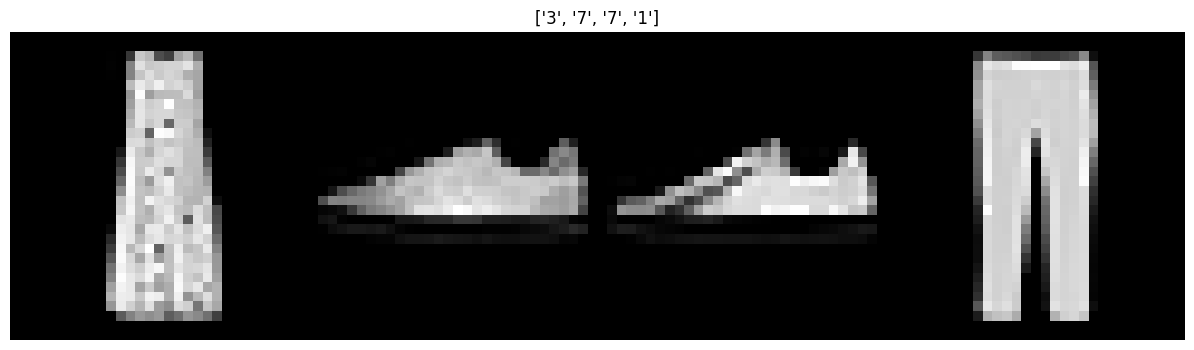

In [9]:
images, labels=show_batch_images(trainloader)

##### **8. 배치 정규화가 적용되지 않은 네트워크**

In [10]:
class NormalNet(nn.Module):
  def __init__(self):
    super(NormalNet, self).__init__()
    self.classifier=nn.Sequential(
        nn.Linear(784, 48),
        nn.ReLU(),
        nn.Linear(48, 24),
        nn.ReLU(),
        nn.Linear(24, 10)
    )

  def forward(self, x):
    x=x.view(x.size(0), -1)
    x=self.classifier(x)
    return x

##### **9. 배치 정규화가 포함된 네트워크**

In [11]:
class BNNet(nn.Module):
  def __init__(self):
    super(BNNet, self).__init__()
    self.classifier=nn.Sequential(
        nn.Linear(784, 48),
        nn.BatchNorm1d(48),
        nn.ReLU(),
        nn.Linear(48, 24),
        nn.BatchNorm1d(24),
        nn.ReLU(),
        nn.Linear(24, 10)
    )

  def forward(self, x):
    x=x.view(x.size(0), -1)
    x=self.classifier(x)
    return x

##### **10. 배치 정규화가 적용되지 않은 모델 선언**

In [12]:
model=NormalNet()
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


##### **11. 배치 정규화가 적용된 모델 선언**

In [13]:
model_bn=BNNet()
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


##### **12. 데이터셋 메모리로 불러오기**

In [14]:
batch_size=512
trainloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

##### **13. 옵티마이저, 손실 함수 지정**

In [15]:
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(model.parameters(), lr=0.01)
opt_bn=optim.SGD(model_bn.parameters(), lr=0.01)

##### **14. 모델 학습**

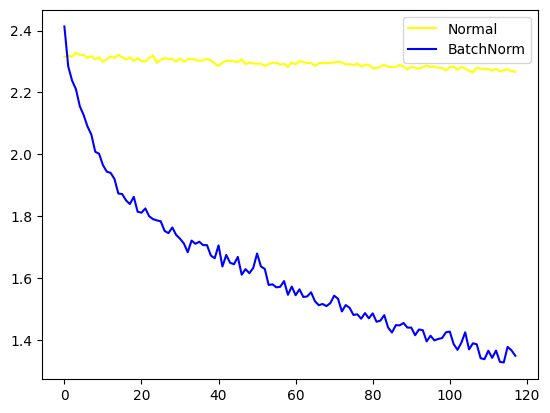

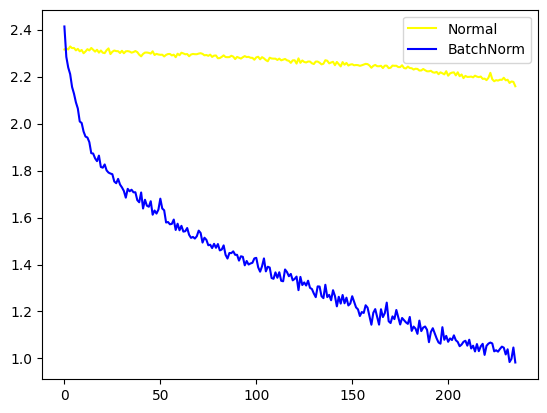

In [16]:
loss_arr=[]
loss_bn_arr=[]
max_epochs=2

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):
    inputs, labels=data
    opt.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    opt_bn.zero_grad()
    outputs_bn=model_bn(inputs)
    loss_bn=loss_fn(outputs_bn, labels)
    loss_bn.backward()
    opt_bn.step()

    loss_arr.append(loss.item())
    loss_bn_arr.append(loss_bn.item())

  plt.plot(loss_arr, 'yellow', label='Normal')
  plt.plot(loss_bn_arr, 'blue', label='BatchNorm')
  plt.legend()
  plt.show()

##### **15. 데이터셋의 분포를 출력하기 위한 전처리**

In [17]:
N=50
noise=0.3

x_train=torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train=x_train+noise*torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

x_test=torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test=x_test+noise*torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

* `torch.linspace`: 주어진 범위에서 균등한 값을 갖는 텐서를 만들기 위해 사용한다.

In [19]:
import torch
# 0부터 10을 100으로 분할
print(torch.linspace(0, 10, 100))
print('---------------')
# 0부터 10을 5로 분할
print(torch.linspace(0, 10, 5))

tensor([ 0.0000,  0.1010,  0.2020,  0.3030,  0.4040,  0.5051,  0.6061,  0.7071,
         0.8081,  0.9091,  1.0101,  1.1111,  1.2121,  1.3131,  1.4141,  1.5152,
         1.6162,  1.7172,  1.8182,  1.9192,  2.0202,  2.1212,  2.2222,  2.3232,
         2.4242,  2.5253,  2.6263,  2.7273,  2.8283,  2.9293,  3.0303,  3.1313,
         3.2323,  3.3333,  3.4343,  3.5354,  3.6364,  3.7374,  3.8384,  3.9394,
         4.0404,  4.1414,  4.2424,  4.3434,  4.4444,  4.5455,  4.6465,  4.7475,
         4.8485,  4.9495,  5.0505,  5.1515,  5.2525,  5.3535,  5.4545,  5.5556,
         5.6566,  5.7576,  5.8586,  5.9596,  6.0606,  6.1616,  6.2626,  6.3636,
         6.4646,  6.5657,  6.6667,  6.7677,  6.8687,  6.9697,  7.0707,  7.1717,
         7.2727,  7.3737,  7.4747,  7.5758,  7.6768,  7.7778,  7.8788,  7.9798,
         8.0808,  8.1818,  8.2828,  8.3838,  8.4848,  8.5859,  8.6869,  8.7879,
         8.8889,  8.9899,  9.0909,  9.1919,  9.2929,  9.3939,  9.4949,  9.5960,
         9.6970,  9.7980,  9.8990, 10.00

##### **16. 데이터 분포를 그래프로 출력**

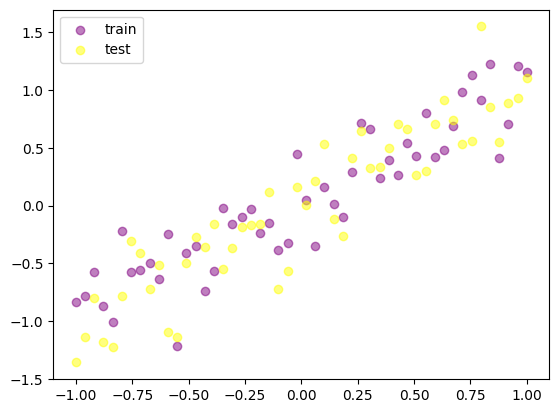

In [20]:
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple',
            alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow',
            alpha=0.5, label='test')
plt.legend()
plt.show()

##### **17. 드롭아웃을 위한 모델 생성**

In [21]:
N_h=100
model=torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1)
)

model_dropout=torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1)
)

##### **18. 옵티마이저, 손실 함수 지정**

In [22]:
opt=torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout=torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn=torch.nn.MSELoss()

##### **19. 모델 학습**

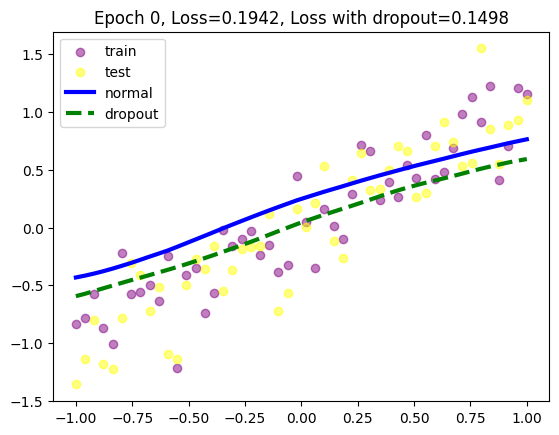

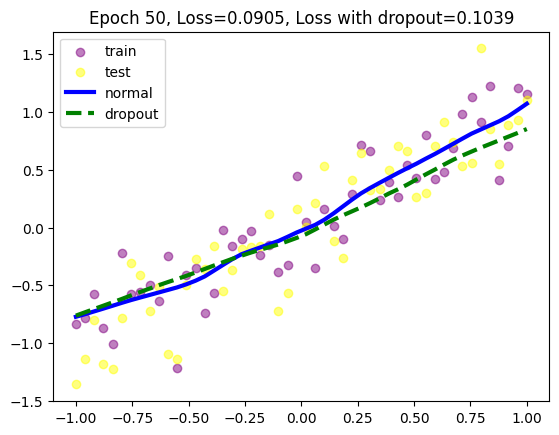

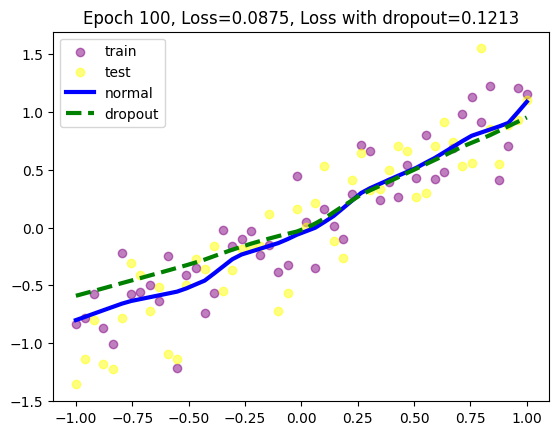

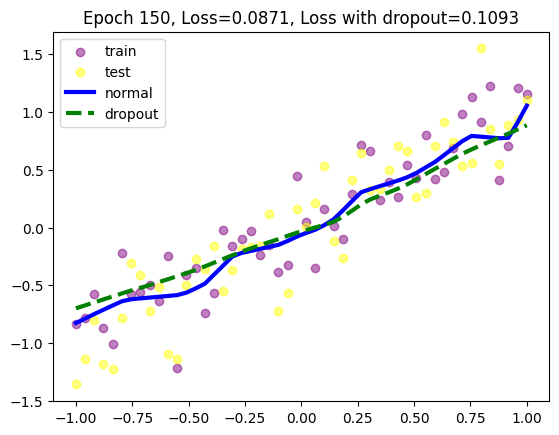

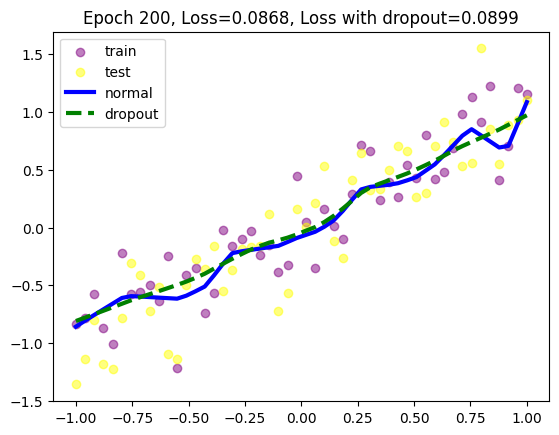

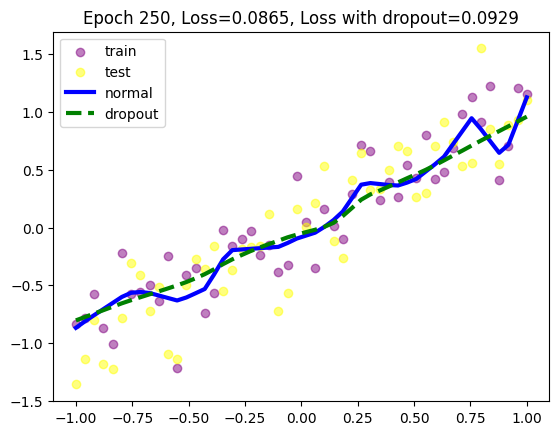

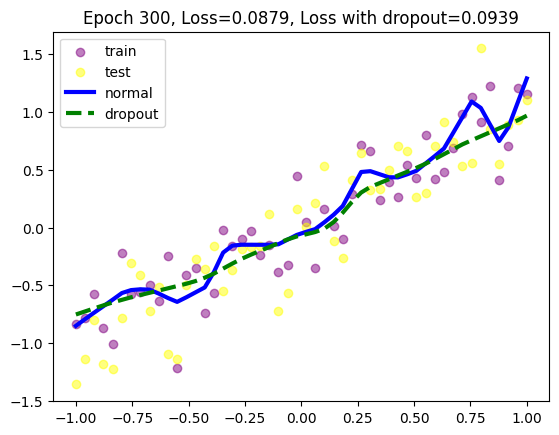

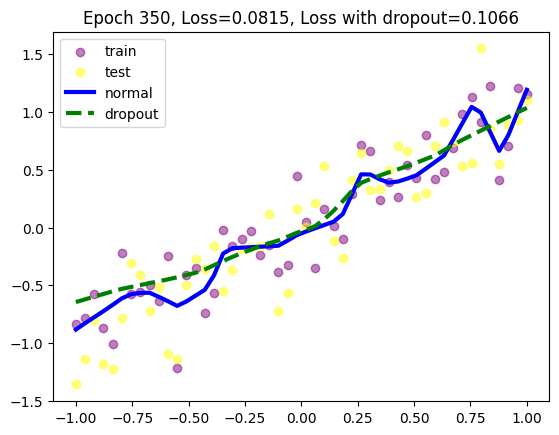

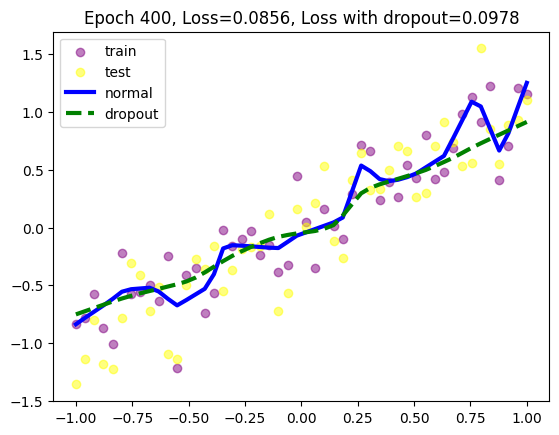

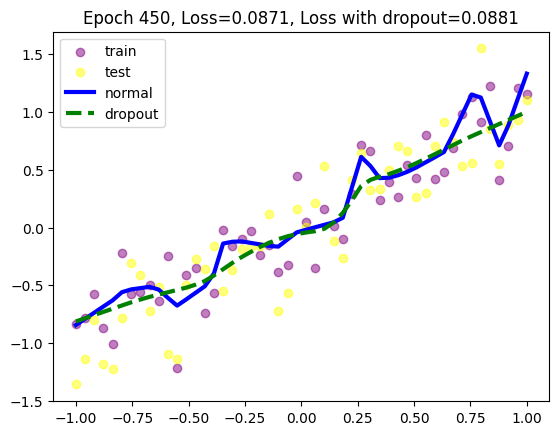

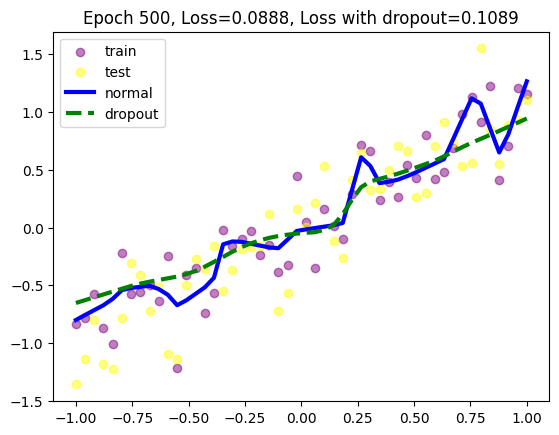

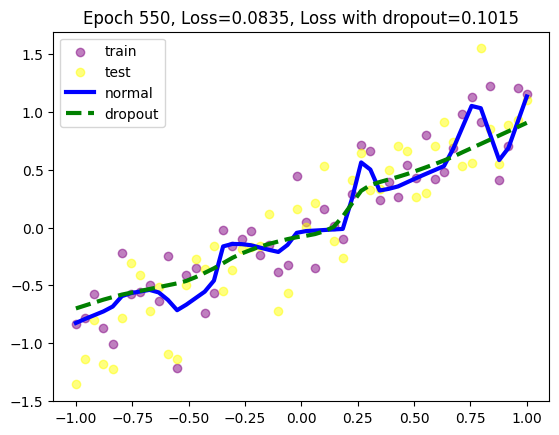

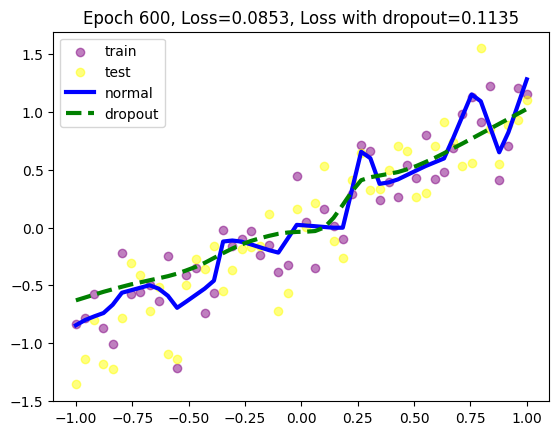

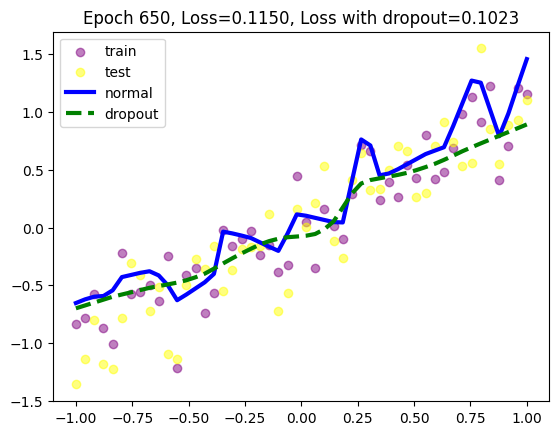

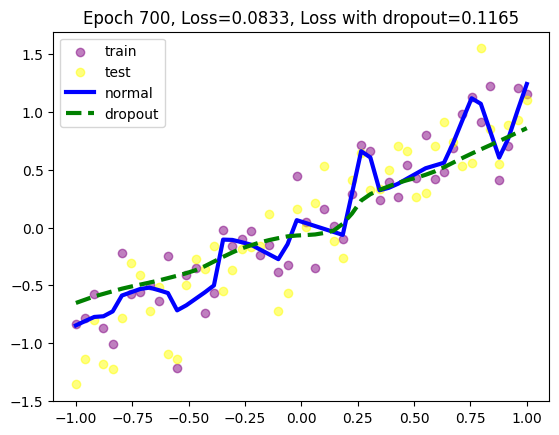

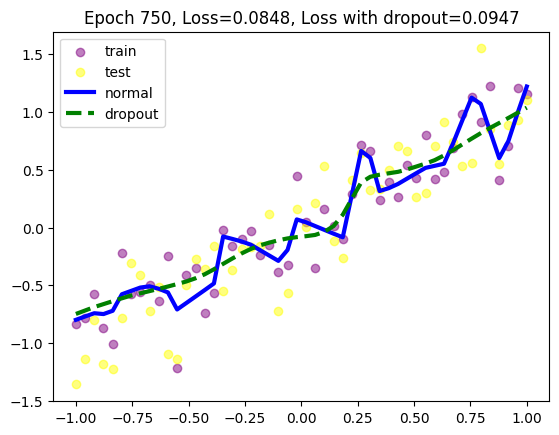

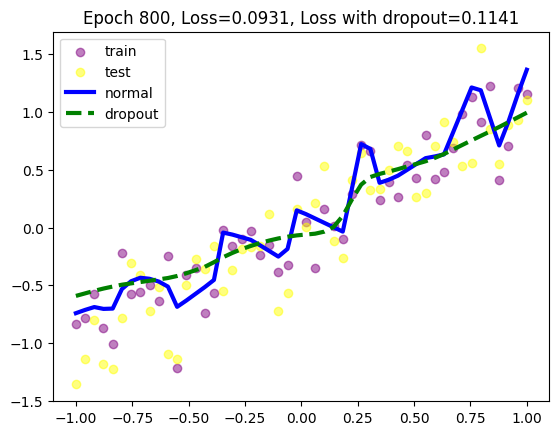

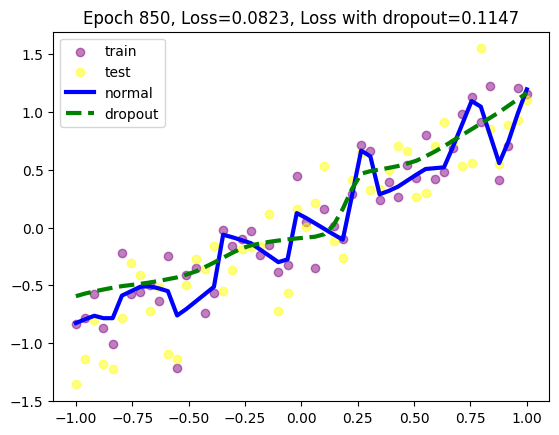

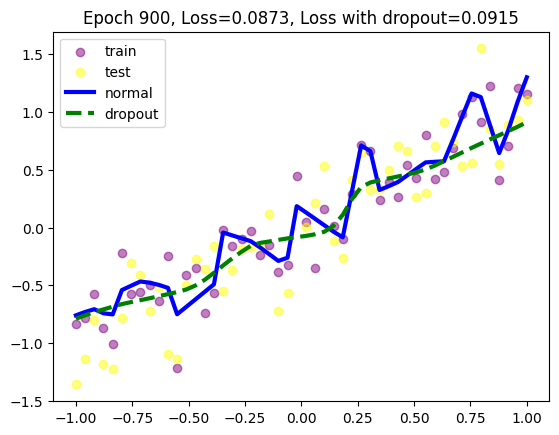

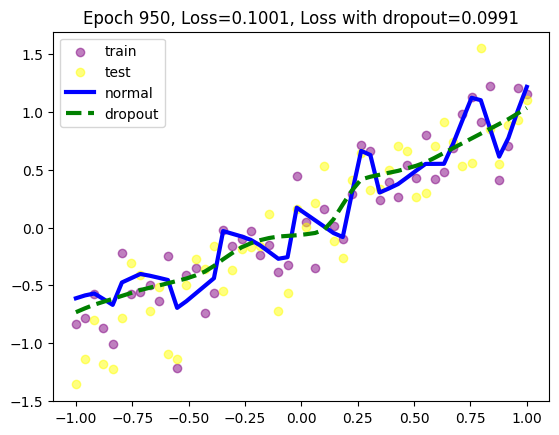

In [23]:
max_epochs=1000
for epoch in range(max_epochs):
  pred=model(x_train)
  loss=loss_fn(pred, y_train)
  opt.zero_grad()
  loss.backward()
  opt.step()

  pred_dropout=model_dropout(x_train)
  loss_dropout=loss_fn(pred_dropout, y_train)
  opt_dropout.zero_grad()
  loss_dropout.backward()
  opt_dropout.step()

  if epoch%50==0:
    model.eval()
    model_dropout.eval()

    test_pred=model(x_test)
    test_loss=loss_fn(test_pred, y_test)

    test_pred_dropout=model_dropout(x_test)
    test_loss_dropout=loss_fn(test_pred_dropout, y_test)

    plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple',
                alpha=0.5, label='train')
    plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow',
                alpha=0.5, label='test')
    plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3,
             label='normal')
    plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,
             label='dropout')
    plt.title('Epoch %d, Loss=%0.4f, Loss with dropout=%0.4f' %(epoch, test_loss, test_loss_dropout))
    plt.legend()
    model.train()
    model_dropout.train()
    plt.pause(0.05)

### **8.3.3 조기 종료를 이용한 성능 최적화**

#### **파이토치 예제**

##### **1. 라이브러리 호출**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets

import matplotlib
import matplotlib.pyplot as plt
import time

import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot')
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

##### **2. 데이터셋 전처리**

In [7]:
train_transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

##### **3. 데이터셋 가져오기**

In [8]:
train_dataset=datasets.ImageFolder(
    root=r'/content/drive/MyDrive/24-2/EURON/과제/Week13/train',
    transform=train_transform
)
train_dataloader=torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
val_dataset=datasets.ImageFolder(
    root=r'/content/drive/MyDrive/24-2/EURON/과제/Week13/test',
    transform=val_transform
)
val_dataloader=torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

##### **4. 모델 생성**

In [9]:
def resnet50(pretrained=True, requires_grad=False):
  model=models.resnet50(progress=True, pretrained=pretrained)
  if requires_grad==False:
    for param in model.parameters():
      param.requires_grad=False
  elif requires_grad==True:
    for param in model.parameters():
      param.requires_grad=True
  model.fc=nn.Linear(2048, 2)
  return model

##### **5. 학습률 감소**

In [10]:
class LRScheduler():
  def __init__(
      self, optimizer, patience=5, min_lr=1e-6, factor=0.5
      ):
    self.optimizer=optimizer
    self.patience=patience
    self.min_lr=min_lr
    self.factor=factor
    self.lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(
        self.optimizer,
        patience=self.patience,
        factor=self.factor,
        min_lr=self.min_lr,
        verbose=True
    )

  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

##### **6. 조기 종료**

In [11]:
class EarlyStopping():
  def __init__(self, patience=5, verbose=False, delta=0,
               path='checkpoint.pt'):
    self.patience=patience
    self.verbose=verbose
    self.counter=0
    self.best_score=None
    self.early_stop=False
    self.val_loss_min=np.Inf
    self.delta=delta
    self.path=path

  def __call__(self, val_loss, model):
    score=-val_loss
    if self.best_score is None:
      self.best_score=score
      self.save_checkpoint(val_loss, model)
    elif score<self.best_score+self.delta:
      self.counter+=1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >=self.patience:
        self.early_stop=True
    else:
      self.best_score=score
      self.save_checkpoint(val_loss, model)
      self.counter=0

  def save_checkpoint(self, val_loss, model):
    if self.verbose:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
    torch.save(model.state_dict(), self.path)
    self.val_loss_min=val_loss

##### **7. 인수 값 지정**

In [12]:
import argparse
import sys

# Reset sys.argv to only include the script name
sys.argv = ['']

In [13]:
parser=argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
args=vars(parser.parse_args())

##### **8. 사전 훈련된 모델의 파라미터 확인**

In [14]:
print(f'Computation device: {device}\n')
model=models.resnet50(pretrained=True).to(device)
total_params=sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params=sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

Computation device: cuda:0



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


25,557,032 total parameters.
25,557,032 training parameters.


학습 가능한 파라미터: 25,557,032개

##### **9. 옵티마이저, 손실 함수 지정**

In [15]:
lr=0.001
epochs=100
optimizer=optim.Adam(model.parameters(), lr=lr)
criterion=nn.CrossEntropyLoss()

##### **10. 오차, 정확도, 모델의 이름에 대한 문자열**

In [16]:
loss_plot_name='loss'
acc_plot_name='accuracy'
model_name='model'

##### **11. 오차, 정확도, 모델의 이름에 대한 문자열**

In [17]:
if args['lr_scheduler']:
  print('INFO: Initializing learning rate scheduler')
  lr_scheduler=LRScheduler(optimizer)
  loss_plot_name='lrs_loss'
  acc_plot_name='lrs_accuracy'
  model_name='lrs_model'
if args['early_stopping']:
  print('INFO: Initializing early stopping')
  early_stopping=EarlyStopping()
  loss_plot_name='es_loss'
  acc_plot_name='es_accuracy'
  model_name='es_model'

##### **12. 모델 학습 함수**

In [18]:
def training(model, train_dataloader, train_dataset, optimizer, criterion):
  print('Training')
  model.train()
  train_running_loss=0.0
  train_running_correct=0
  counter=0
  total=0
  prog_bar=tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
  for i, data in prog_bar:
    counter+=1
    data, target=data[0].to(device), data[1].to(device)
    total+=target.size(0)
    optimizer.zero_grad()
    outputs=model(data)
    loss=criterion(outputs, target)
    train_running_loss+=loss.item()
    _, preds=torch.max(outputs.data, 1)
    train_running_correct+=(preds==target).sum().item()
    loss.backward()
    optimizer.step()

  train_loss=train_running_loss/counter
  train_accuracy=100. * train_running_correct/total
  return train_loss, train_accuracy

##### **13. 모델 검증 함수**

In [21]:
def validate(model, test_dataloader, val_dataset, criterion):
  print('Validating')
  model.eval()
  val_running_loss=0.0
  val_running_correct=0
  counter=0
  total=0
  prog_bar=tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
  with torch.no_grad():
    for i, data in prog_bar:
      counter+=1
      data, target=data[0].to(device), data[1].to(device)
      total+=target.size(0)
      outputs=model(data)
      loss=criterion(outputs, target)

      val_running_loss+=loss.item()
      _, preds=torch.max(outputs.data, 1)
      val_running_correct+=(preds==target).sum().item()

    val_loss=val_running_loss/counter
    val_accuracy=100.*val_running_correct/total
    return val_loss, val_accuracy

##### **14. 모델 학습**

In [22]:
train_loss, train_accuracy=[], []
val_loss, val_accuracy=[], []
start=time.time()
for epoch in range(epochs):
  print(f'Epoch {epoch+1} of {epochs}')
  train_epoch_loss, train_epoch_accuracy=training(model, train_dataloader, train_dataset, optimizer, criterion)
  val_epoch_loss, val_epoch_accuracy=validate(model, val_dataloader, val_dataset, criterion)
  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)
  val_loss.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)
  if args['lr_scheduler']:
    lr_scheduler(val_epoch_loss)
  if args['early_stopping']:
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop:
      break
  print(f'Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}')
  print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end=time.time()
print(f'Training time: {(end-start)/60:.3f} minutes')

Epoch 1 of 100
Training


16it [00:05,  2.87it/s]


Validating


16it [02:27,  9.20s/it]


Train Loss: 0.6717, Train Acc: 65.26
Val Loss: 1.1653, Val Acc: 55.40
Epoch 2 of 100
Training


16it [00:05,  2.70it/s]


Validating


16it [00:04,  3.37it/s]


Train Loss: 0.5314, Train Acc: 70.88
Val Loss: 0.5504, Val Acc: 74.20
Epoch 3 of 100
Training


16it [00:05,  3.05it/s]


Validating


16it [00:05,  2.99it/s]


Train Loss: 0.4161, Train Acc: 80.32
Val Loss: 0.5639, Val Acc: 76.00
Epoch 4 of 100
Training


16it [00:05,  3.09it/s]


Validating


16it [00:05,  3.04it/s]


Train Loss: 0.3808, Train Acc: 81.93
Val Loss: 0.9099, Val Acc: 68.00
Epoch 5 of 100
Training


16it [00:05,  2.99it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.3570, Train Acc: 83.13
Val Loss: 1.0174, Val Acc: 73.20
Epoch 6 of 100
Training


16it [00:05,  2.72it/s]


Validating


16it [00:04,  3.38it/s]


Train Loss: 0.3203, Train Acc: 86.14
Val Loss: 0.6429, Val Acc: 72.60
Epoch 7 of 100
Training


16it [00:05,  2.85it/s]


Validating


16it [00:04,  3.28it/s]


Train Loss: 0.3258, Train Acc: 86.95
Val Loss: 0.8259, Val Acc: 72.80
Epoch 8 of 100
Training


16it [00:05,  3.05it/s]


Validating


16it [00:05,  2.97it/s]


Train Loss: 0.2433, Train Acc: 89.36
Val Loss: 0.7700, Val Acc: 72.40
Epoch 9 of 100
Training


16it [00:05,  3.07it/s]


Validating


16it [00:04,  3.20it/s]


Train Loss: 0.2170, Train Acc: 90.76
Val Loss: 1.1193, Val Acc: 67.00
Epoch 10 of 100
Training


16it [00:05,  2.85it/s]


Validating


16it [00:04,  3.38it/s]


Train Loss: 0.1780, Train Acc: 91.97
Val Loss: 0.7706, Val Acc: 75.20
Epoch 11 of 100
Training


16it [00:06,  2.64it/s]


Validating


16it [00:04,  3.32it/s]


Train Loss: 0.2123, Train Acc: 90.76
Val Loss: 0.6301, Val Acc: 78.80
Epoch 12 of 100
Training


16it [00:05,  2.88it/s]


Validating


16it [00:05,  3.02it/s]


Train Loss: 0.2322, Train Acc: 90.56
Val Loss: 1.1733, Val Acc: 68.40
Epoch 13 of 100
Training


16it [00:05,  3.02it/s]


Validating


16it [00:05,  2.93it/s]


Train Loss: 0.2036, Train Acc: 92.77
Val Loss: 0.5997, Val Acc: 75.20
Epoch 14 of 100
Training


16it [00:05,  3.02it/s]


Validating


16it [00:04,  3.23it/s]


Train Loss: 0.1933, Train Acc: 92.77
Val Loss: 1.7747, Val Acc: 65.20
Epoch 15 of 100
Training


16it [00:05,  2.73it/s]


Validating


16it [00:04,  3.29it/s]


Train Loss: 0.1932, Train Acc: 93.17
Val Loss: 0.8430, Val Acc: 72.60
Epoch 16 of 100
Training


16it [00:06,  2.65it/s]


Validating


16it [00:04,  3.35it/s]


Train Loss: 0.2043, Train Acc: 92.37
Val Loss: 0.6296, Val Acc: 74.80
Epoch 17 of 100
Training


16it [00:05,  3.00it/s]


Validating


16it [00:05,  3.02it/s]


Train Loss: 0.2929, Train Acc: 89.96
Val Loss: 0.8163, Val Acc: 75.40
Epoch 18 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:05,  3.00it/s]


Train Loss: 0.2195, Train Acc: 92.37
Val Loss: 0.6508, Val Acc: 78.60
Epoch 19 of 100
Training


16it [00:05,  3.00it/s]


Validating


16it [00:04,  3.39it/s]


Train Loss: 0.1786, Train Acc: 94.38
Val Loss: 0.6866, Val Acc: 76.60
Epoch 20 of 100
Training


16it [00:05,  2.71it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.1376, Train Acc: 94.18
Val Loss: 0.6901, Val Acc: 79.40
Epoch 21 of 100
Training


16it [00:05,  2.77it/s]


Validating


16it [00:04,  3.28it/s]


Train Loss: 0.1252, Train Acc: 95.18
Val Loss: 0.8960, Val Acc: 74.40
Epoch 22 of 100
Training


16it [00:05,  3.06it/s]


Validating


16it [00:05,  2.89it/s]


Train Loss: 0.0979, Train Acc: 96.59
Val Loss: 0.8523, Val Acc: 73.80
Epoch 23 of 100
Training


16it [00:05,  3.03it/s]


Validating


16it [00:05,  3.11it/s]


Train Loss: 0.0626, Train Acc: 98.19
Val Loss: 0.6302, Val Acc: 77.40
Epoch 24 of 100
Training


16it [00:05,  2.88it/s]


Validating


16it [00:04,  3.35it/s]


Train Loss: 0.0557, Train Acc: 97.99
Val Loss: 0.7855, Val Acc: 76.40
Epoch 25 of 100
Training


16it [00:05,  2.68it/s]


Validating


16it [00:04,  3.31it/s]


Train Loss: 0.0732, Train Acc: 97.19
Val Loss: 1.0370, Val Acc: 74.60
Epoch 26 of 100
Training


16it [00:05,  2.84it/s]


Validating


16it [00:05,  3.13it/s]


Train Loss: 0.1750, Train Acc: 92.77
Val Loss: 0.7445, Val Acc: 71.40
Epoch 27 of 100
Training


16it [00:05,  3.02it/s]


Validating


16it [00:05,  2.90it/s]


Train Loss: 0.1089, Train Acc: 96.18
Val Loss: 0.7349, Val Acc: 72.80
Epoch 28 of 100
Training


16it [00:05,  3.01it/s]


Validating


16it [00:04,  3.20it/s]


Train Loss: 0.1057, Train Acc: 96.18
Val Loss: 1.4519, Val Acc: 70.20
Epoch 29 of 100
Training


16it [00:05,  2.82it/s]


Validating


16it [00:04,  3.38it/s]


Train Loss: 0.1214, Train Acc: 94.98
Val Loss: 0.6737, Val Acc: 78.60
Epoch 30 of 100
Training


16it [00:05,  2.70it/s]


Validating


16it [00:04,  3.37it/s]


Train Loss: 0.1489, Train Acc: 92.97
Val Loss: 0.8037, Val Acc: 73.80
Epoch 31 of 100
Training


16it [00:05,  2.96it/s]


Validating


16it [00:05,  3.08it/s]


Train Loss: 0.0702, Train Acc: 97.59
Val Loss: 0.5921, Val Acc: 79.20
Epoch 32 of 100
Training


16it [00:05,  3.06it/s]


Validating


16it [00:05,  2.98it/s]


Train Loss: 0.0508, Train Acc: 97.99
Val Loss: 0.7435, Val Acc: 78.20
Epoch 33 of 100
Training


16it [00:05,  3.07it/s]


Validating


16it [00:04,  3.30it/s]


Train Loss: 0.0383, Train Acc: 98.39
Val Loss: 0.8331, Val Acc: 78.80
Epoch 34 of 100
Training


16it [00:06,  2.64it/s]


Validating


16it [00:04,  3.39it/s]


Train Loss: 0.0973, Train Acc: 96.99
Val Loss: 1.0427, Val Acc: 73.80
Epoch 35 of 100
Training


16it [00:05,  2.77it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.0999, Train Acc: 95.58
Val Loss: 1.0243, Val Acc: 74.20
Epoch 36 of 100
Training


16it [00:05,  3.03it/s]


Validating


16it [00:05,  2.94it/s]


Train Loss: 0.1239, Train Acc: 96.59
Val Loss: 0.7749, Val Acc: 77.40
Epoch 37 of 100
Training


16it [00:05,  3.08it/s]


Validating


16it [00:05,  3.14it/s]


Train Loss: 0.1035, Train Acc: 97.19
Val Loss: 0.8868, Val Acc: 72.80
Epoch 38 of 100
Training


16it [00:05,  2.93it/s]


Validating


16it [00:04,  3.40it/s]


Train Loss: 0.0908, Train Acc: 97.39
Val Loss: 0.8764, Val Acc: 76.80
Epoch 39 of 100
Training


16it [00:05,  2.69it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.0891, Train Acc: 96.59
Val Loss: 0.8226, Val Acc: 75.00
Epoch 40 of 100
Training


16it [00:05,  2.92it/s]


Validating


16it [00:05,  3.14it/s]


Train Loss: 0.0722, Train Acc: 97.79
Val Loss: 1.2537, Val Acc: 73.80
Epoch 41 of 100
Training


16it [00:05,  3.05it/s]


Validating


16it [00:05,  2.94it/s]


Train Loss: 0.1210, Train Acc: 97.39
Val Loss: 0.9164, Val Acc: 75.20
Epoch 42 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:04,  3.34it/s]


Train Loss: 0.1011, Train Acc: 95.98
Val Loss: 1.1213, Val Acc: 76.20
Epoch 43 of 100
Training


16it [00:05,  2.76it/s]


Validating


16it [00:04,  3.39it/s]


Train Loss: 0.0704, Train Acc: 97.99
Val Loss: 0.8866, Val Acc: 75.80
Epoch 44 of 100
Training


16it [00:05,  2.74it/s]


Validating


16it [00:04,  3.37it/s]


Train Loss: 0.0872, Train Acc: 96.39
Val Loss: 0.9360, Val Acc: 72.80
Epoch 45 of 100
Training


16it [00:05,  2.97it/s]


Validating


16it [00:05,  2.82it/s]


Train Loss: 0.0999, Train Acc: 96.18
Val Loss: 1.1227, Val Acc: 69.80
Epoch 46 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:05,  3.02it/s]


Train Loss: 0.1125, Train Acc: 95.78
Val Loss: 0.9877, Val Acc: 73.00
Epoch 47 of 100
Training


16it [00:05,  2.98it/s]


Validating


16it [00:04,  3.40it/s]


Train Loss: 0.0936, Train Acc: 96.59
Val Loss: 0.7570, Val Acc: 75.80
Epoch 48 of 100
Training


16it [00:05,  2.71it/s]


Validating


16it [00:04,  3.37it/s]


Train Loss: 0.0970, Train Acc: 96.18
Val Loss: 1.1866, Val Acc: 72.00
Epoch 49 of 100
Training


16it [00:05,  2.83it/s]


Validating


16it [00:04,  3.25it/s]


Train Loss: 0.0955, Train Acc: 96.79
Val Loss: 0.9028, Val Acc: 75.60
Epoch 50 of 100
Training


16it [00:05,  3.08it/s]


Validating


16it [00:05,  2.95it/s]


Train Loss: 0.1028, Train Acc: 97.59
Val Loss: 0.8674, Val Acc: 74.20
Epoch 51 of 100
Training


16it [00:05,  3.06it/s]


Validating


16it [00:05,  3.18it/s]


Train Loss: 0.1154, Train Acc: 96.18
Val Loss: 0.7884, Val Acc: 78.00
Epoch 52 of 100
Training


16it [00:05,  2.84it/s]


Validating


16it [00:04,  3.37it/s]


Train Loss: 0.0715, Train Acc: 96.59
Val Loss: 0.7342, Val Acc: 77.60
Epoch 53 of 100
Training


16it [00:05,  2.69it/s]


Validating


16it [00:04,  3.39it/s]


Train Loss: 0.0489, Train Acc: 98.19
Val Loss: 0.9756, Val Acc: 75.20
Epoch 54 of 100
Training


16it [00:05,  3.03it/s]


Validating


16it [00:05,  3.06it/s]


Train Loss: 0.0414, Train Acc: 97.99
Val Loss: 0.8545, Val Acc: 76.40
Epoch 55 of 100
Training


16it [00:05,  3.05it/s]


Validating


16it [00:05,  3.03it/s]


Train Loss: 0.0451, Train Acc: 98.39
Val Loss: 0.8935, Val Acc: 76.60
Epoch 56 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.0518, Train Acc: 98.59
Val Loss: 0.9402, Val Acc: 77.60
Epoch 57 of 100
Training


16it [00:06,  2.61it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.0507, Train Acc: 98.19
Val Loss: 1.2343, Val Acc: 73.00
Epoch 58 of 100
Training


16it [00:05,  2.77it/s]


Validating


16it [00:04,  3.30it/s]


Train Loss: 0.0600, Train Acc: 97.99
Val Loss: 1.4214, Val Acc: 68.60
Epoch 59 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:05,  2.97it/s]


Train Loss: 0.1052, Train Acc: 96.59
Val Loss: 1.5242, Val Acc: 67.80
Epoch 60 of 100
Training


16it [00:05,  3.03it/s]


Validating


16it [00:05,  3.14it/s]


Train Loss: 0.0902, Train Acc: 97.19
Val Loss: 0.9100, Val Acc: 73.00
Epoch 61 of 100
Training


16it [00:05,  2.87it/s]


Validating


16it [00:04,  3.33it/s]


Train Loss: 0.0367, Train Acc: 98.80
Val Loss: 0.6651, Val Acc: 78.00
Epoch 62 of 100
Training


16it [00:06,  2.66it/s]


Validating


16it [00:04,  3.39it/s]


Train Loss: 0.0370, Train Acc: 99.00
Val Loss: 0.7002, Val Acc: 79.20
Epoch 63 of 100
Training


16it [00:05,  2.92it/s]


Validating


16it [00:05,  3.16it/s]


Train Loss: 0.0569, Train Acc: 97.79
Val Loss: 1.0683, Val Acc: 74.20
Epoch 64 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:05,  2.93it/s]


Train Loss: 0.0845, Train Acc: 97.39
Val Loss: 1.3166, Val Acc: 68.60
Epoch 65 of 100
Training


16it [00:05,  3.06it/s]


Validating


16it [00:04,  3.31it/s]


Train Loss: 0.0784, Train Acc: 96.59
Val Loss: 0.9009, Val Acc: 77.80
Epoch 66 of 100
Training


16it [00:05,  2.71it/s]


Validating


16it [00:04,  3.37it/s]


Train Loss: 0.0488, Train Acc: 99.00
Val Loss: 0.9728, Val Acc: 76.80
Epoch 67 of 100
Training


16it [00:06,  2.66it/s]


Validating


16it [00:04,  3.35it/s]


Train Loss: 0.0412, Train Acc: 98.39
Val Loss: 0.7527, Val Acc: 79.00
Epoch 68 of 100
Training


16it [00:05,  3.08it/s]


Validating


16it [00:05,  2.90it/s]


Train Loss: 0.0403, Train Acc: 99.40
Val Loss: 0.9619, Val Acc: 79.60
Epoch 69 of 100
Training


16it [00:05,  3.06it/s]


Validating


16it [00:05,  2.99it/s]


Train Loss: 0.0550, Train Acc: 98.39
Val Loss: 0.7593, Val Acc: 77.20
Epoch 70 of 100
Training


16it [00:05,  2.98it/s]


Validating


16it [00:04,  3.33it/s]


Train Loss: 0.0521, Train Acc: 98.80
Val Loss: 1.0204, Val Acc: 76.00
Epoch 71 of 100
Training


16it [00:05,  2.69it/s]


Validating


16it [00:04,  3.35it/s]


Train Loss: 0.0601, Train Acc: 97.79
Val Loss: 0.8304, Val Acc: 76.60
Epoch 72 of 100
Training


16it [00:05,  2.75it/s]


Validating


16it [00:04,  3.31it/s]


Train Loss: 0.0943, Train Acc: 97.19
Val Loss: 0.8050, Val Acc: 78.00
Epoch 73 of 100
Training


16it [00:05,  3.05it/s]


Validating


16it [00:05,  2.95it/s]


Train Loss: 0.0442, Train Acc: 97.99
Val Loss: 1.1776, Val Acc: 74.40
Epoch 74 of 100
Training


16it [00:05,  3.00it/s]


Validating


16it [00:05,  3.05it/s]


Train Loss: 0.0317, Train Acc: 99.00
Val Loss: 0.9203, Val Acc: 75.00
Epoch 75 of 100
Training


16it [00:05,  2.88it/s]


Validating


16it [00:04,  3.34it/s]


Train Loss: 0.0506, Train Acc: 98.39
Val Loss: 0.9633, Val Acc: 77.20
Epoch 76 of 100
Training


16it [00:05,  2.69it/s]


Validating


16it [00:04,  3.33it/s]


Train Loss: 0.0392, Train Acc: 99.00
Val Loss: 0.8993, Val Acc: 78.00
Epoch 77 of 100
Training


16it [00:05,  2.86it/s]


Validating


16it [00:04,  3.23it/s]


Train Loss: 0.0265, Train Acc: 99.00
Val Loss: 1.3450, Val Acc: 70.00
Epoch 78 of 100
Training


16it [00:05,  3.06it/s]


Validating


16it [00:05,  2.97it/s]


Train Loss: 0.0452, Train Acc: 97.99
Val Loss: 0.9548, Val Acc: 79.00
Epoch 79 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:04,  3.23it/s]


Train Loss: 0.0662, Train Acc: 97.79
Val Loss: 1.0835, Val Acc: 77.20
Epoch 80 of 100
Training


16it [00:05,  2.74it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.0766, Train Acc: 97.19
Val Loss: 1.2628, Val Acc: 75.80
Epoch 81 of 100
Training


16it [00:05,  2.72it/s]


Validating


16it [00:04,  3.37it/s]


Train Loss: 0.0837, Train Acc: 97.39
Val Loss: 1.3210, Val Acc: 69.00
Epoch 82 of 100
Training


16it [00:05,  2.97it/s]


Validating


16it [00:05,  3.13it/s]


Train Loss: 0.0719, Train Acc: 97.99
Val Loss: 1.3159, Val Acc: 76.40
Epoch 83 of 100
Training


16it [00:05,  3.07it/s]


Validating


16it [00:05,  2.99it/s]


Train Loss: 0.0809, Train Acc: 97.19
Val Loss: 0.9051, Val Acc: 72.20
Epoch 84 of 100
Training


16it [00:05,  3.05it/s]


Validating


16it [00:04,  3.29it/s]


Train Loss: 0.0779, Train Acc: 97.19
Val Loss: 0.8572, Val Acc: 77.20
Epoch 85 of 100
Training


16it [00:05,  2.71it/s]


Validating


16it [00:04,  3.38it/s]


Train Loss: 0.0532, Train Acc: 97.99
Val Loss: 0.8120, Val Acc: 78.80
Epoch 86 of 100
Training


16it [00:05,  2.76it/s]


Validating


16it [00:04,  3.32it/s]


Train Loss: 0.0552, Train Acc: 98.19
Val Loss: 0.8287, Val Acc: 79.40
Epoch 87 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:05,  2.98it/s]


Train Loss: 0.0788, Train Acc: 97.39
Val Loss: 0.8095, Val Acc: 81.60
Epoch 88 of 100
Training


16it [00:05,  3.06it/s]


Validating


16it [00:05,  3.07it/s]


Train Loss: 0.0617, Train Acc: 97.59
Val Loss: 1.0563, Val Acc: 72.20
Epoch 89 of 100
Training


16it [00:05,  2.96it/s]


Validating


16it [00:04,  3.33it/s]


Train Loss: 0.0374, Train Acc: 98.59
Val Loss: 1.0558, Val Acc: 75.20
Epoch 90 of 100
Training


16it [00:05,  2.70it/s]


Validating


16it [00:04,  3.37it/s]


Train Loss: 0.0261, Train Acc: 99.80
Val Loss: 0.9409, Val Acc: 75.60
Epoch 91 of 100
Training


16it [00:05,  2.83it/s]


Validating


16it [00:04,  3.23it/s]


Train Loss: 0.0754, Train Acc: 97.39
Val Loss: 1.8250, Val Acc: 66.20
Epoch 92 of 100
Training


16it [00:05,  3.02it/s]


Validating


16it [00:05,  2.95it/s]


Train Loss: 0.0414, Train Acc: 98.39
Val Loss: 1.3730, Val Acc: 71.20
Epoch 93 of 100
Training


16it [00:05,  3.03it/s]


Validating


16it [00:05,  3.14it/s]


Train Loss: 0.0422, Train Acc: 98.59
Val Loss: 0.9562, Val Acc: 74.60
Epoch 94 of 100
Training


16it [00:05,  2.88it/s]


Validating


16it [00:04,  3.38it/s]


Train Loss: 0.0478, Train Acc: 98.80
Val Loss: 0.9607, Val Acc: 76.40
Epoch 95 of 100
Training


16it [00:05,  2.73it/s]


Validating


16it [00:04,  3.34it/s]


Train Loss: 0.0602, Train Acc: 97.79
Val Loss: 1.2170, Val Acc: 74.60
Epoch 96 of 100
Training


16it [00:05,  2.88it/s]


Validating


16it [00:05,  3.14it/s]


Train Loss: 0.0699, Train Acc: 97.59
Val Loss: 0.9248, Val Acc: 76.00
Epoch 97 of 100
Training


16it [00:05,  3.05it/s]


Validating


16it [00:05,  2.96it/s]


Train Loss: 0.0456, Train Acc: 98.39
Val Loss: 0.9380, Val Acc: 76.20
Epoch 98 of 100
Training


16it [00:05,  3.05it/s]


Validating


16it [00:04,  3.28it/s]


Train Loss: 0.0332, Train Acc: 98.39
Val Loss: 1.1265, Val Acc: 71.80
Epoch 99 of 100
Training


16it [00:05,  2.78it/s]


Validating


16it [00:04,  3.38it/s]


Train Loss: 0.0537, Train Acc: 98.80
Val Loss: 1.0436, Val Acc: 78.20
Epoch 100 of 100
Training


16it [00:05,  2.73it/s]


Validating


16it [00:04,  3.37it/s]

Train Loss: 0.0292, Train Acc: 99.00
Val Loss: 1.0057, Val Acc: 75.60
Training time: 19.977 minutes


##### **15. 모델 학습 결과 출력**

Saving loss and accuracy plots...


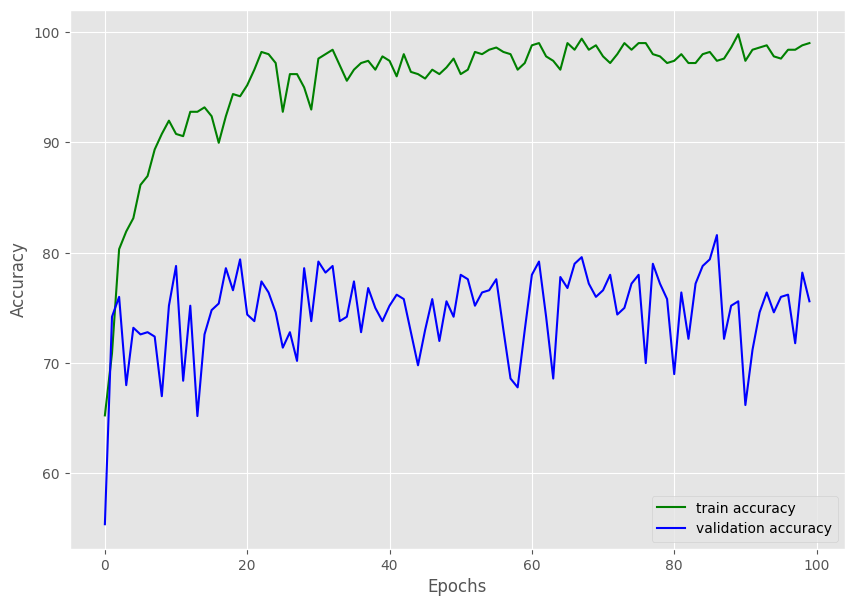

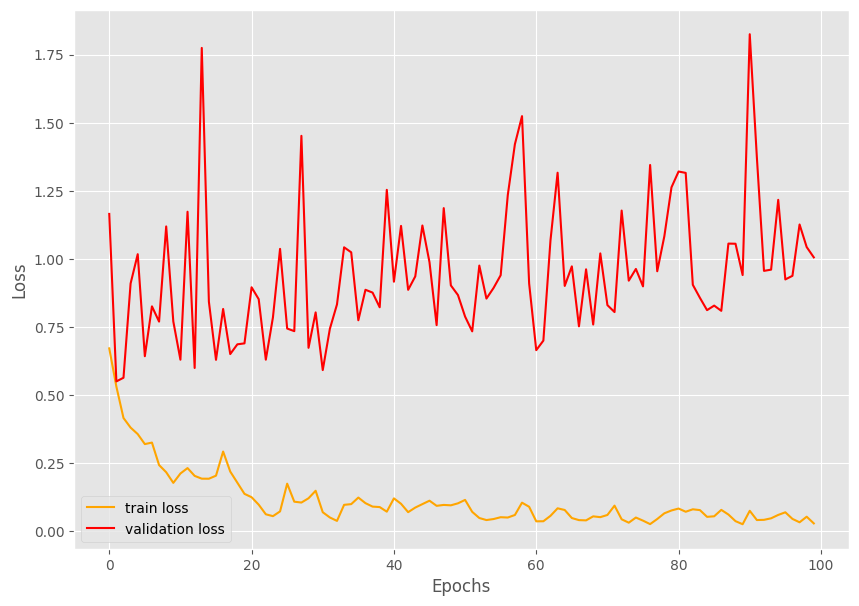

Saving model...
TRAINING COMPLETE


In [23]:
print('Saving loss and accuracy plots...')
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'{acc_plot_name}.png')
plt.show()
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{loss_plot_name}.png')
plt.show()

print('Saving model...')
torch.save(model.state_dict(), f'{model_name}.pt')
print('TRAINING COMPLETE')